# PGA Tour Analysis
Which aspects of a pro golfer’s game leads to the most success?

### Load and Trim the Data
Brad Klassen has scraped all PGA tour statistics from 2010-2018 from their official website and published them in a csv on Kaggle. The dataset contains:
    
    -3053 golfers
    -2081 variables
    -528 statistics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
##show all the columns 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 3000)
pd.set_option('display.width', 3000)

In [2]:
## raw string to avoid error
df = pd.read_csv(r'C:\Users\garf\PGAcapstone\PGA_Data_Historical.csv', thousands=',')
# ##unstack the multi-levels in new dataframe
PGA_historic = df.set_index(['Player Name', 'Variable', 'Season'])['Value'].unstack('Variable').reset_index()

In [3]:
##rename money
PGA_historic.rename(columns={'Total Money (Official and Unofficial) - (MONEY)':'Money'}, inplace=True)

In [4]:
## remove $ and commas from money column
PGA_historic['Money']= PGA_historic['Money'].str.replace('$','')
PGA_historic['Money']= PGA_historic['Money'].str.replace(',','')
##fill money NaN with 0 and convert to int so we can order it
PGA_historic['Money'] = pd.to_numeric(PGA_historic['Money'].fillna(0))

In [5]:
## sort by avg score, the target variable
PGA_historic.sort_values(by='Scoring Average (Actual) - (AVG)', inplace=True)

In [6]:
## reset index
PGA_historic.reset_index(drop=True, inplace=True)

In [7]:
## group by player name and total money earned
grouped_df = PGA_historic.groupby(['Player Name'])['Money'].sum().reset_index()

In [8]:
## sort by money and only keep the top 200 golfers
grouped_sorted = grouped_df.sort_values('Money', ascending=False).head(200).reset_index(drop=True)

In [9]:
## get a list of the top 200 golfers
top200list = grouped_sorted['Player Name'].tolist()

In [10]:
## drop all golfers outside of top 200
top200df = PGA_historic[PGA_historic['Player Name'].isin(top200list)]

### Data Cleaning
We strip down characters and convert all statistical columns to numeric ones. 

In [11]:
# drop text based descriptive columns
drop_columns = ['Longest Drives - (TOURNAMENT)','Longest Hole Outs (in yards) - (TOURNAMENT)',
                'Longest Putts - (YEAR/TOURN#)','Lowest Round - (TOURN/COURSE)',
                'Going for the Green - Hit Green Pct. - (RTP-NOT GOING FOR THE GRN)',
                'Official World Golf Ranking - (COUNTRY)','Putting Average - (GIR RANK)']
top200df.drop(drop_columns,axis=1,inplace=True)

c:\python34\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Our next task is to get the columns ready to be converted to numeric types. A few issues that stand out initially are columns that are measured in:
    1. Feet' Inches"
    2. + or - relative to par
    3. Numbers with commas
    
The commas can easily be replaced before converting, but we'll need to write a function to convert our feet' inches" to inches and one to handle the positive or negative numbers that are in string format.

In [12]:
def feet_to_inches(num):
    try:
    ##check to see if its in our ft'in" format
        if num.endswith('\"'):
            # strip last inches character
            num = num.replace('\"', '')
            #seperate at the apostrophe
            feet, sep, inches = num.partition('\'')
            # add feet to inches
            num = float(feet) + float(inches)
            return num
        else:
            return num
    except:
        return num

In [13]:
def golf_score_to_float(num):
    try:
        if num.startswith('+'):
            return float(num.replace('+',''))
        if num.startswith('-'):
            return float(num.replace('-','')) * -1
        if num == 'E':
            return 0
        else:
            return num
    except:
        return num

In [14]:
def strip_comma(num):
    try:
        return num.replace(',','')
    except:
        return num

In [15]:
def strip_apostrophe(num):
    try:
        return num.replace('\'','')
    except:
        return num

In [16]:
def strip_dollar_sign(num):
    try:
        return num.replace('$','')
    except:
        return num

In [17]:
# change golf score to int
top200df = top200df.applymap(golf_score_to_float)

In [18]:
# change ft' in" format to inches
top200df = top200df.applymap(feet_to_inches)

In [19]:
# strip commas
top200df = top200df.applymap(strip_comma)

In [20]:
# strip apostrophe
top200df = top200df.applymap(strip_apostrophe)

In [21]:
# strip dollar sign
top200df = top200df.applymap(strip_dollar_sign)

In [22]:
# to numeric
top200df = top200df.apply(lambda x: pd.to_numeric(x, errors='ignore'))

### Missing Values
Filling the nulls with the mean makes the most sense and has the best results because the top 200 golfers in the world won't have any true outliers where they are so much better or worse in any one statistic.

In [23]:
## this will drop all columns with more than 40% null
top200df = top200df.loc[:, top200df.isnull().mean() < .4]

In [24]:
# fill with mean
top200df.fillna(top200df.mean(), inplace=True)

### Exploring the Target Variable
In my first iteration, money earned on tour was the target variable. However, it became clear that a season of golf stats alone are not able to explain much of the variance of that variable, perhaps because certain golf tournaments, such as the Masters, pay so much more money than the minor ones. 

The better target variable for explaining which aspects of golf help a golfer succeed is average score. The best example is Jordan Spieth's 2015 season, which is the highest grossing season for a golfer in this dataset, but has the 6th best scoring average.

In [25]:
## rename scoring
top200df.rename(columns={'Scoring Average (Actual) - (AVG)':'Avg Score'}, inplace=True)

In [26]:
# create new df for model
pga_df = top200df[['Player Name','Season','Avg Score']].sort_values(by='Avg Score')

In [27]:
pga_df['Avg Score'].describe()

count    1711.000000
mean       70.748494
std         0.508780
min        68.540000
25%        70.520000
50%        70.748494
75%        70.930000
max        74.220000
Name: Avg Score, dtype: float64

Text(0.5, 1.0, 'Avg Score Distribution')

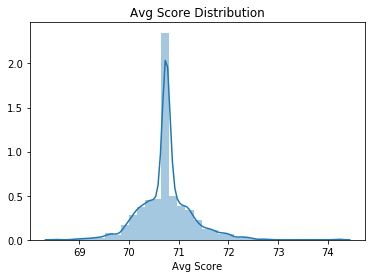

In [28]:
# plot score
sns.distplot(pga_df['Avg Score'], bins=35)
plt.title('Avg Score Distribution')

Our target variable is normally distributed, with a slight skew to the right.

These are the 10 worst seasons:

These are the best 10 seasons:

In [29]:
top200df[['Player Name','Season','Avg Score','Money']].head(10)

Variable,Player Name,Season,Avg Score,Money
0,Dustin Johnson,2018,68.54,8564352
1,Jason Day,2015,68.89,9938330
2,Jordan Spieth,2017,68.94,9573033
3,Justin Rose,2018,69.03,8275678
4,Justin Thomas,2018,69.06,8809821
5,Jordan Spieth,2015,69.09,13030465
6,Webb Simpson,2011,69.16,6579853
7,Steve Stricker,2013,69.19,4590532
8,Webb Simpson,2018,69.25,5376417
9,Rory McIlroy,2014,69.27,8395096


In [30]:
pga_df.tail(10)

Variable,Player Name,Season,Avg Score
1658,Ernie Els,2017,72.40
1660,Brendon Todd,2016,72.44
1661,Greg Chalmers,2018,72.44
1662,Daniel Summerhays,2018,72.47
1664,Si Woo Kim,2017,72.51
1665,Sung Kang,2012,72.66
1668,Matt Every,2015,72.71
1673,Robert Allenby,2016,72.82
1676,Steven Bowditch,2016,74.20
1677,Steven Bowditch,2017,74.22


### Feature Selection 
This data set contains many columns that could potentially be selected, however the majority of them overlap by collecting data on some nuance of a golf statistic. We'll distill the categories that they represent down to the best representations of the core parts of a golf game. From my lifelong obsession with golf, these are essentially putting, driving accuracy, driving distance, fairway to green accuracy, and scrambling. In this section we'll determine which columns of the dataset will be used to represent these categories.

After many iterations, and comparting several feature sets, the best performers to explain the slight difference in skill between the top 200 golfers are as gollows:

    -Putts made over 10ft
    -Driving Accuracy
    -Avg Driving Distance
    -GIR Pct From Fairway
    -Scrambling Pct

In [31]:
features = ['Putts Made Per Event Over 10\' - (PUTTS MADE)','Driving Accuracy Percentage - (%)','Driving Distance - (AVG.)',
            'GIR Percentage from Fairway - (%)','Scrambling - (%)']


# add features
pga_df[features] = top200df[features]

In [32]:
# rename features
pga_df.rename(columns={'Putts Made Per Event Over 10\' - (PUTTS MADE)' : 'Putts over 10ft', 
                       'Driving Accuracy Percentage - (%)' : 'Driving Accuracy',
                       'Driving Distance - (AVG.)' : 'Avg Driving Distance',
                       'GIR Percentage from Fairway - (%)' : 'GIR Pct From Fairway',
                       'Scrambling - (%)' : 'Scrambling Pct'}, inplace=True)

Variable,Avg Score,Putts over 10ft,Driving Accuracy,Avg Driving Distance,GIR Pct From Fairway,Scrambling Pct
Variable,,,,,,
Avg Score,1.000000,-0.600168,-0.209774,-0.234445,-0.479335,-0.564299
Putts over 10ft,-0.600168,1.000000,0.119070,0.106857,0.233065,0.311638
Driving Accuracy,-0.209774,0.119070,1.000000,-0.559453,-0.123173,0.229299
Avg Driving Distance,-0.234445,0.106857,-0.559453,1.000000,0.516216,-0.262082
GIR Pct From Fairway,-0.479335,0.233065,-0.123173,0.516216,1.000000,-0.088383
Scrambling Pct,-0.564299,0.311638,0.229299,-0.262082,-0.088383,1.000000


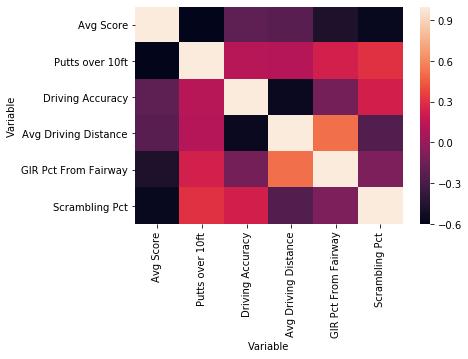

In [33]:
## plot correlations
sns.heatmap(pga_df.drop(columns='Season').corr())
pga_df.drop(columns='Season').corr()

## could take the minus of avg score to be more understandable

The putts made over 10 ft was the big surprise performer. It vastly outperforms the base level avg putting statistic bc pros are all so proficient at short putts. This feature was able to explain much more variance among them.

Driving accuracy and distance are not as strong factors as expected, again it seems to be due to all top golfers being of equal skill in those regards.

It seems that being able to make long putts, hit the green from the fairway, and recovering when you don't, are the most signifcant factors leading to success.

count    1711.000000
mean        5.122095
std         0.769341
min         2.600000
25%         4.800000
50%         5.122095
75%         5.400000
max         8.100000
Name: Putts over 10ft, dtype: float64

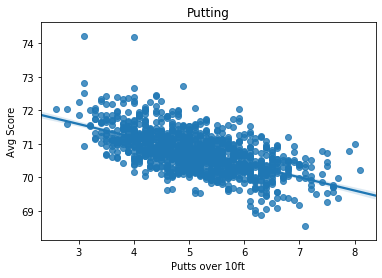

In [50]:
# plot putting to score
sns.regplot(x='Putts over 10ft',y='Avg Score',data=pga_df)
plt.title('Putting')
pga_df['Putts over 10ft'].describe()

count    1711.000000
mean       61.481948
std         4.186775
min        43.020000
25%        59.520000
50%        61.481948
75%        63.425000
max        76.880000
Name: Driving Accuracy, dtype: float64

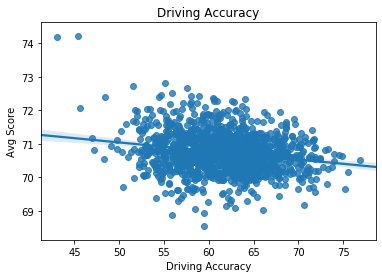

In [51]:
# plot Driving Accuracy to score
sns.regplot(x='Driving Accuracy',y='Avg Score',data=pga_df)
plt.title('Driving Accuracy')
pga_df['Driving Accuracy'].describe()

count    1711.000000
mean      291.593944
std         7.555467
min       266.400000
25%       288.100000
50%       291.593944
75%       294.700000
max       319.700000
Name: Avg Driving Distance, dtype: float64

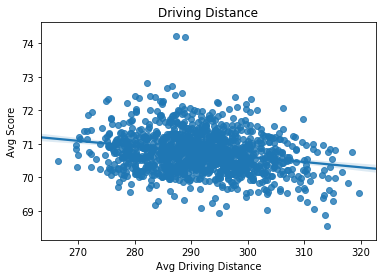

In [53]:
# plot Driving distance to score
sns.regplot(x='Avg Driving Distance',y='Avg Score',data=pga_df)
plt.title('Driving Distance')
pga_df['Avg Driving Distance'].describe()

count    1711.000000
mean       76.593887
std         2.365883
min        65.150000
25%        75.670000
50%        76.593887
75%        77.825000
max        84.860000
Name: GIR Pct From Fairway, dtype: float64

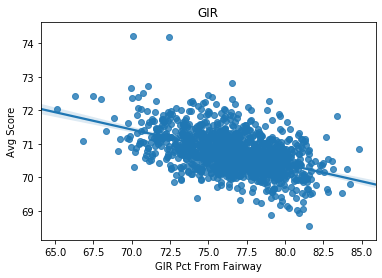

In [54]:
# plot GIR Pct From Fairway to score
sns.regplot(x='GIR Pct From Fairway',y='Avg Score',data=pga_df)
plt.title('GIR')
pga_df['GIR Pct From Fairway'].describe()

count    1711.000000
mean       58.450286
std         2.767487
min        48.010000
25%        57.230000
50%        58.450286
75%        59.760000
max        69.330000
Name: Scrambling Pct, dtype: float64

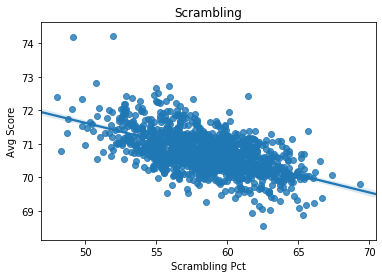

In [56]:
# plot Scrambling Pct to score
sns.regplot(x='Scrambling Pct',y='Avg Score',data=pga_df)
plt.title('Scrambling')
pga_df['Scrambling Pct'].describe()

### Build Initial Regression Model
First, we'll build a model to interpret which statistics explain the variance of avg score. Later, we'll try to predict avg scores for a golfer for a season.

In [39]:
# create variables
X, Y = pga_df.drop(['Avg Score','Player Name','Season'], axis=1), pga_df['Avg Score']

In [40]:
# add constant since we're using statsmodel and not sklearn
X = sm.add_constant(X)

c:\python34\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [41]:
#fit OLS regression model to explain with coefficients
results = sm.OLS(Y,X).fit()

In [42]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Avg Score   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1090.
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:33:28   Log-Likelihood:                -43.867
No. Observations:                1711   AIC:                             99.73
Df Residuals:                    1705   BIC:                             132.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   91.2461 

In order to increase avg score by 1 stroke do one of the following:
 - Increase driving accuracy by about 30%
   - Very Difficult, 7.2 standard deviations
 - Increase avg driving distance by about 50 yds
   - Very Difficult, 6.6 standard deviations
 - Increase GIR pct from fairway by about 17%
   - Very Difficult, 7.3 standard deviations
 - Increase scrambling pct by about 10%
   - Much more reasonable, 3.6 standard deviations
 - Increase putts made over 10’ by 1 putt per round
   - Seems obvious, but this is by far the best opportunity to improve versus the rest of the field, less than 1 standard deviation


#### Predictions

In [43]:
# reset variables
X, Y = pga_df.drop(['Avg Score','Player Name'], axis=1), pga_df[['Avg Score','Season']]

In [44]:
## split into train and test sets
X_train = X.loc[X['Season'] != 2018]
X_test = X.loc[X['Season'] == 2018]

# drop the season identifier feature
X_train = X_train.drop('Season', axis=1)
X_test = X_test.drop('Season', axis=1)

# create Y test and train variables
Y_train = Y.loc[Y['Season'] != 2018]
Y_test = Y.loc[Y['Season'] == 2018]

# drop the season identifier feature
Y_train = Y_train.drop('Season', axis=1)
Y_test = Y_test.drop('Season', axis=1)

# #Scaling decreased the performance on the test set
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

print("The number of observations in training set is {}".format(X_train.shape))
print("The number of observations in test set is {}".format(X_test.shape))

The number of observations in training set is (1523, 5)
The number of observations in test set is (188, 5)


In [45]:
# Fitting a regression model
linreg = LinearRegression() 
results = linreg.fit(X_train, Y_train)

# predictions
Y_preds_train = linreg.predict(X_train)
Y_preds_test = linreg.predict(X_test)

print("R-squared of the model on the training set is: {}".format(linreg.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(linreg.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))

R-squared of the model on the training set is: 0.7538573177100395
-----Test set statistics-----
R-squared of the model on the test set is: 0.7860022990887687
Mean absolute error of the prediction is: 0.17212987185289252


In [46]:
# make predictions
Y_pred = results.predict(X_test)

Text(0, 0.5, 'Margin of Error in Strokes')

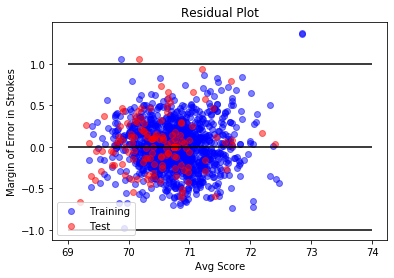

In [49]:
# Scatter plot the training data
train = plt.scatter(Y_preds_train,(Y_train-Y_preds_train),c='b',alpha=0.5)

# Scatter plot the testing data
test = plt.scatter(Y_preds_test,(Y_test-Y_preds_test),c='r',alpha=0.5)

# Plot a horizontal axis line at 0
plt.hlines(y=1,xmin=69,xmax=74)
plt.hlines(y=0,xmin=69,xmax=74)
plt.hlines(y=-1,xmin=69,xmax=74)
#Labels
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('Residual Plot')
plt.xlabel('Avg Score')
plt.ylabel('Margin of Error in Strokes')

Our model is pretty good! It predicted every avg score within +/- 1 stroke with only a couple exceptions, and the average prediction is off by only .17 of a stroke.

### Conclusions

    - Practicing long putting is the best use of time
    - Driving distance and accuracy are not good indicators of a successful golfer
    - Golf shots have an inherent collinearity 
    - The model is a good start for sports betting predictions
     - Is it more useful than simply using avg score itself?
     - Could narrow it to these features by specific golf course, weather conditions, etc.
